In [26]:
from ENDFtk.tree import Tape
import glob
import numpy as np
import matplotlib.pyplot as plt

original_tape = Tape.from_file('/home/sole-pie01/ndlib/endfb8-neutron/n-092_U_233.endf')
mf2 = original_tape.materials.front().MF(2).MT(151).parse()
original_params = {}
for l, orbital in enumerate(mf2.isotopes[0].resonance_ranges[0].parameters.l_values):
    original_params[l] = {
        'ER': np.array(orbital.ER),
        'GN': np.array(orbital.GN),
        'GG': np.array(orbital.GG),
        'GFA': np.array(orbital.GFB),  # Note: assuming GFA is GFB based on code
        'GFB': np.array(orbital.GFA)
    }

In [27]:
sampled_files = sorted(glob.glob("../FreeGazScattering/sampled*.endf"))
sampled_params = {l: {param: [] for param in ['ER', 'GN', 'GG', 'GFA', 'GFB']} for l in original_params}

for file in sampled_files:
    endf_tape = Tape.from_file(file)
    mf2 = endf_tape.materials.front().MF(2).MT(151).parse()
    rrr = mf2.isotopes[0].resonance_ranges[0]
    for l, orbital in enumerate(rrr.parameters.l_values):
        if l in sampled_params:  # Ensure l exists in original
            sampled_params[l]['ER'].append(np.array(orbital.ER))
            sampled_params[l]['GN'].append(np.array(orbital.GN))
            sampled_params[l]['GG'].append(np.array(orbital.GG))
            sampled_params[l]['GFA'].append(np.array(orbital.GFB))
            sampled_params[l]['GFB'].append(np.array(orbital.GFA))

In [28]:
# Check data structure
print("Number of sampled files:", len(sampled_files))
print("L values in original_params:", list(original_params.keys()))

# Check shapes for each L value
for l in original_params:
    print(f"\nL = {l}:")
    for param in ['ER', 'GN', 'GG', 'GFA', 'GFB']:
        original_count = len(original_params[l][param])
        sampled_count = len(sampled_params[l][param]) if sampled_params[l][param] else 0
        sampled_shape = np.array(sampled_params[l][param]).shape if sampled_params[l][param] else "empty"
        print(f"  {param}: original {original_count} resonances, {sampled_count} samples, shape {sampled_shape}")

Number of sampled files: 100
L values in original_params: [0]

L = 0:
  ER: original 770 resonances, 100 samples, shape (100, 770)
  GN: original 770 resonances, 100 samples, shape (100, 770)
  GG: original 770 resonances, 100 samples, shape (100, 770)
  GFA: original 770 resonances, 100 samples, shape (100, 770)
  GFB: original 770 resonances, 100 samples, shape (100, 770)


In [29]:
# Check why there's a mismatch in number of resonances
print("Original ER shape:", original_params[0]['ER'].shape)
print("First few original ER values:", original_params[0]['ER'][:5])

print("\nFirst sampled file ER shape:", np.array(sampled_params[0]['ER'][0]).shape)
print("First few sampled ER values:", np.array(sampled_params[0]['ER'][0])[:5])

# Let's work with the intersection of resonances (first 404)
num_resonances_to_use = min(len(original_params[0]['ER']), len(sampled_params[0]['ER'][0]))
print(f"\nUsing {num_resonances_to_use} resonances for analysis")

Original ER shape: (770,)
First few original ER values: [-1060.   -800.   -575.   -387.5  -237.5]

First sampled file ER shape: (770,)
First few sampled ER values: [-1063.30687   -798.383616  -576.879808  -387.659371  -236.647167]

Using 770 resonances for analysis


In [30]:
# Calculate running means for convergence analysis
def calculate_running_means(sampled_data, original_data, num_resonances):
    """Calculate normalized running means for convergence analysis"""
    num_samples = len(sampled_data)
    running_means = np.zeros((num_samples, num_resonances))
    
    for sample_idx in range(num_samples):
        # Calculate running mean up to current sample
        current_samples = sampled_data[:sample_idx+1]
        running_mean = np.mean(current_samples, axis=0)
        
        # Normalize by original values (avoid division by zero)
        normalized_running_mean = np.where(original_data[:num_resonances] != 0, 
                                         running_mean / original_data[:num_resonances], 
                                         running_mean)
        running_means[sample_idx] = normalized_running_mean
    
    return running_means

# Calculate running means for all parameters
l_value = 0  # We only have L=0 from the data
params = ['ER', 'GN', 'GG', 'GFA', 'GFB']
normalized_running_means = {}

for param in params:
    print(f"Calculating running means for {param}...")
    sampled_data = np.array(sampled_params[l_value][param])
    original_data = original_params[l_value][param]
    
    normalized_running_means[param] = calculate_running_means(
        sampled_data, original_data, num_resonances_to_use
    )

print("Running means calculation completed!")

Calculating running means for ER...
Calculating running means for GN...
Calculating running means for GG...
Calculating running means for GFA...
Calculating running means for GFB...
Running means calculation completed!


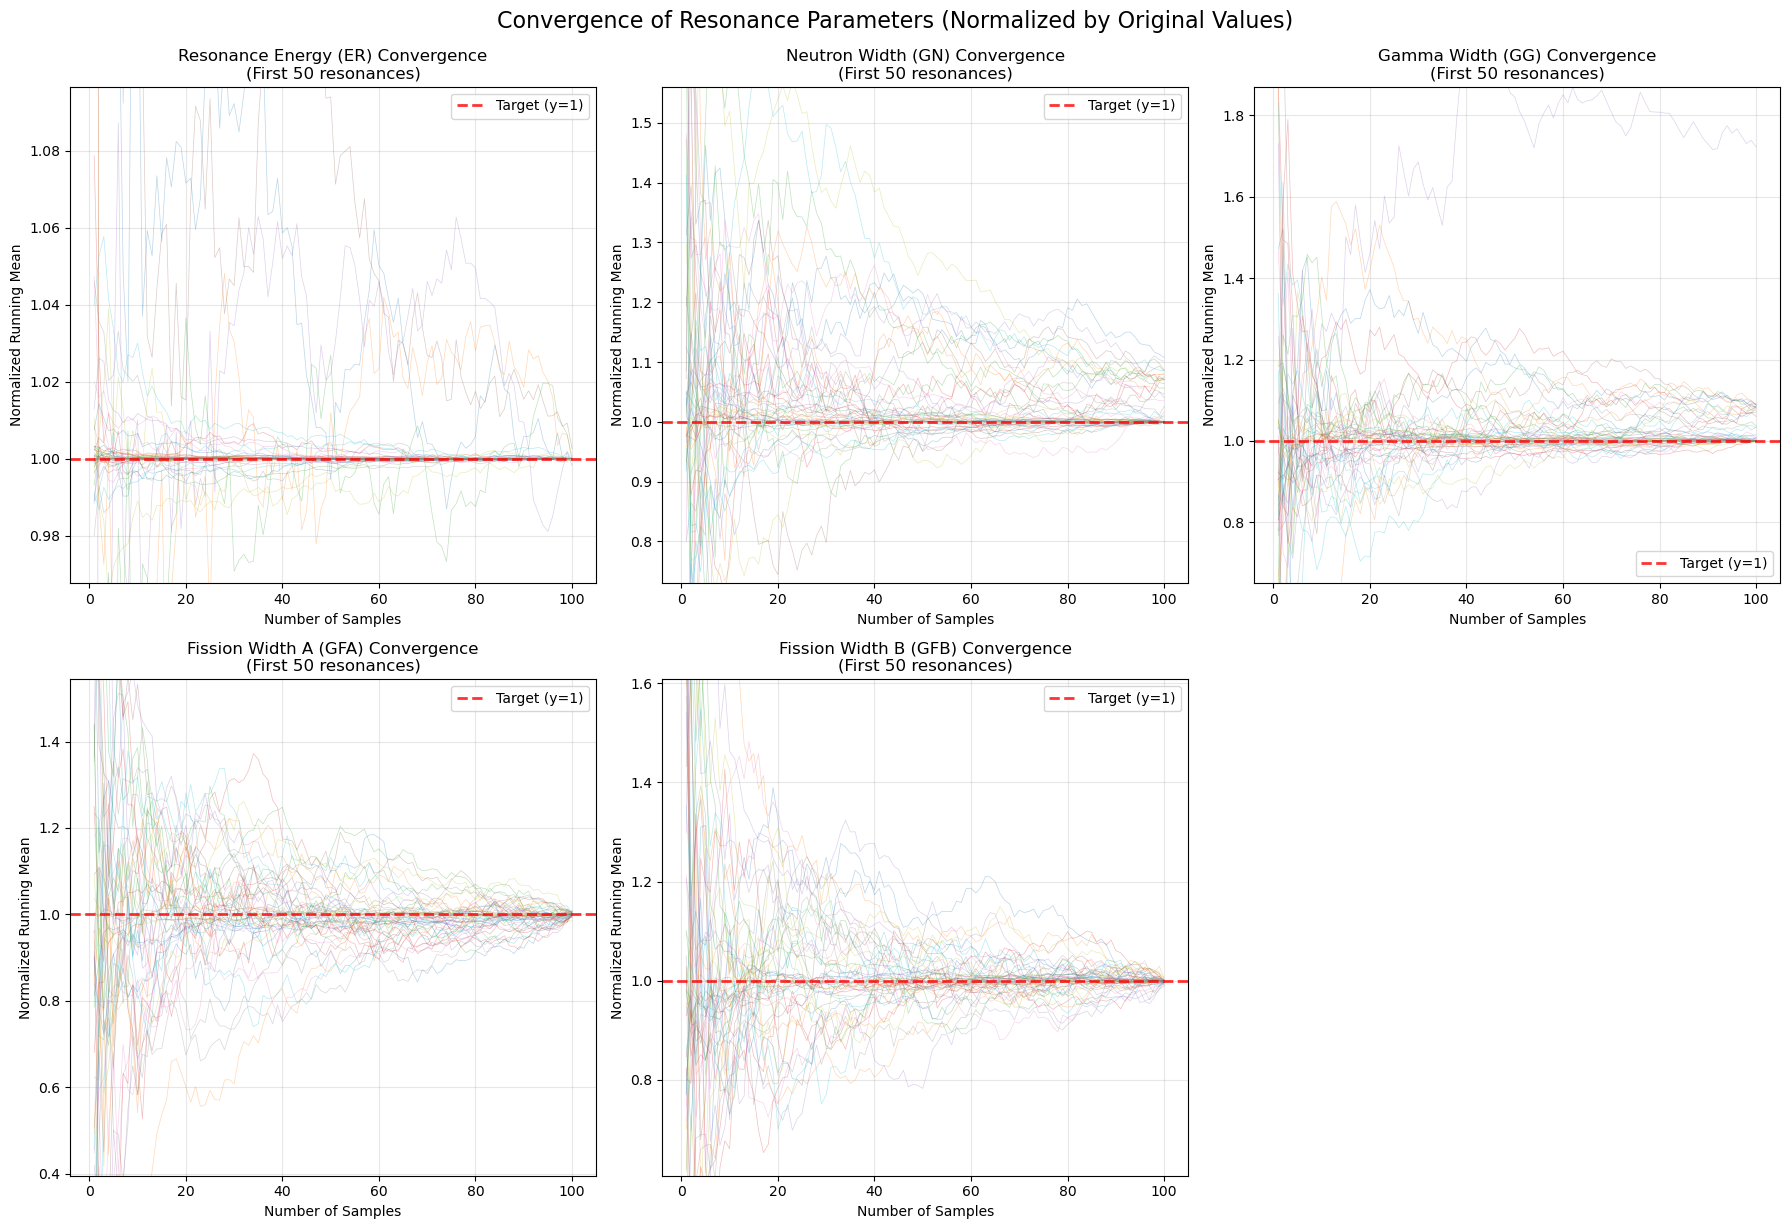

Convergence plots completed!


In [31]:
# Create convergence plots for each parameter
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

param_titles = {
    'ER': 'Resonance Energy (ER)',
    'GN': 'Neutron Width (GN)', 
    'GG': 'Gamma Width (GG)',
    'GFA': 'Fission Width A (GFA)',
    'GFB': 'Fission Width B (GFB)'
}

# Sample indices for plotting (to avoid too many lines)
sample_indices = np.arange(1, len(sampled_files) + 1)
resonances_to_plot = min(50, num_resonances_to_use)  # Plot first 50 resonances for clarity

for i, param in enumerate(params):
    ax = axes[i]
    
    # Plot convergence for each resonance (first resonances_to_plot)
    for res_idx in range(resonances_to_plot):
        ax.plot(sample_indices, normalized_running_means[param][:, res_idx], 
                alpha=0.3, linewidth=0.5)
    
    # Add reference line at y=1 (perfect convergence)
    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Target (y=1)')
    
    ax.set_xlabel('Number of Samples')
    ax.set_ylabel('Normalized Running Mean')
    ax.set_title(f'{param_titles[param]} Convergence\n(First {resonances_to_plot} resonances)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set reasonable y-limits
    y_data = normalized_running_means[param][:, :resonances_to_plot]
    y_min, y_max = np.percentile(y_data, [1, 99])
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

# Remove the empty subplot
axes[5].remove()

plt.tight_layout()
plt.suptitle('Convergence of Resonance Parameters (Normalized by Original Values)', 
             fontsize=16, y=1.02)
plt.show()

print("Convergence plots completed!")

In [32]:
# Statistical compatibility test: Final estimates vs nominal values
from scipy import stats

print("STATISTICAL COMPATIBILITY ANALYSIS")
print("=" * 50)

# Use final 20 samples to assess convergence (exclude initial transient)
final_samples = 20
compatibility_results = {}

for param in params:
    print(f"\n{param_titles[param]} ({param}):")
    print("-" * 40)
    
    # Get final estimates (average of last final_samples)
    final_estimates = normalized_running_means[param][-final_samples:, :]
    final_mean = np.mean(final_estimates, axis=0)
    final_std = np.std(final_estimates, axis=0)
    
    # Statistical tests
    # 1. One-sample t-test against theoretical mean of 1.0
    t_stats, p_values = stats.ttest_1samp(final_estimates, 1.0, axis=0)
    
    # 2. Compatibility metrics
    within_1pct = np.sum(np.abs(final_mean - 1.0) < 0.01)
    within_5pct = np.sum(np.abs(final_mean - 1.0) < 0.05)
    within_10pct = np.sum(np.abs(final_mean - 1.0) < 0.10)
    
    # 3. Mean statistics
    overall_bias = np.mean(final_mean - 1.0)
    overall_rmse = np.sqrt(np.mean((final_mean - 1.0)**2))
    
    # 4. Significance test summary
    significant_deviations = np.sum(p_values < 0.05)
    
    compatibility_results[param] = {
        'bias': overall_bias,
        'rmse': overall_rmse,
        'within_1pct': within_1pct,
        'within_5pct': within_5pct,
        'within_10pct': within_10pct,
        'significant_deviations': significant_deviations
    }
    
    print(f"  Mean bias: {overall_bias:+.4f}")
    print(f"  RMSE: {overall_rmse:.4f}")
    print(f"  Within 1%: {within_1pct}/{num_resonances_to_use} ({100*within_1pct/num_resonances_to_use:.1f}%)")
    print(f"  Within 5%: {within_5pct}/{num_resonances_to_use} ({100*within_5pct/num_resonances_to_use:.1f}%)")
    print(f"  Within 10%: {within_10pct}/{num_resonances_to_use} ({100*within_10pct/num_resonances_to_use:.1f}%)")
    print(f"  Significant deviations (p<0.05): {significant_deviations}/{num_resonances_to_use} ({100*significant_deviations/num_resonances_to_use:.1f}%)")

print(f"\nOVERALL ASSESSMENT")
print("=" * 50)

# Summary statistics
total_resonances = num_resonances_to_use * len(params)
total_within_5pct = sum(r['within_5pct'] for r in compatibility_results.values())
total_significant = sum(r['significant_deviations'] for r in compatibility_results.values())

print(f"Total parameter-resonance combinations: {total_resonances}")
print(f"Overall within 5% of nominal: {total_within_5pct}/{total_resonances} ({100*total_within_5pct/total_resonances:.1f}%)")
print(f"Overall significant deviations: {total_significant}/{total_resonances} ({100*total_significant/total_resonances:.1f}%)")

# Conclusion
if total_within_5pct/total_resonances > 0.95:
    conclusion = "EXCELLENT compatibility - >95% within 5%"
elif total_within_5pct/total_resonances > 0.90:
    conclusion = "GOOD compatibility - >90% within 5%"
elif total_within_5pct/total_resonances > 0.80:
    conclusion = "ACCEPTABLE compatibility - >80% within 5%"
else:
    conclusion = "POOR compatibility - <80% within 5%"

print(f"\nCONCLUSION: {conclusion}")
print(f"The sampled parameters show {'good' if total_within_5pct/total_resonances > 0.90 else 'limited'} statistical compatibility with nominal values.")

STATISTICAL COMPATIBILITY ANALYSIS

Resonance Energy (ER) (ER):
----------------------------------------
  Mean bias: +0.0001
  RMSE: 0.0011
  Within 1%: 768/770 (99.7%)
  Within 5%: 770/770 (100.0%)
  Within 10%: 770/770 (100.0%)
  Significant deviations (p<0.05): 617/770 (80.1%)

Neutron Width (GN) (GN):
----------------------------------------
  Mean bias: +0.0090
  RMSE: 0.0270
  Within 1%: 626/770 (81.3%)
  Within 5%: 706/770 (91.7%)
  Within 10%: 754/770 (97.9%)
  Significant deviations (p<0.05): 655/770 (85.1%)

Gamma Width (GG) (GG):
----------------------------------------
  Mean bias: +0.0146
  RMSE: 0.0426
  Within 1%: 578/770 (75.1%)
  Within 5%: 663/770 (86.1%)
  Within 10%: 747/770 (97.0%)
  Significant deviations (p<0.05): 716/770 (93.0%)

Fission Width A (GFA) (GFA):
----------------------------------------
  Mean bias: -0.0001
  RMSE: 0.0147
  Within 1%: 562/770 (73.0%)
  Within 5%: 760/770 (98.7%)
  Within 10%: 770/770 (100.0%)
  Significant deviations (p<0.05): 636/7

/home/sole-pie01/.local/share/mamba/envs/nd/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:618: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)
